In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Goals

The goal for this notebook is to introduce various loss functions and work through a Gradient Descent algorithm.

Gradient Descent will be implemented for you in most Data Science or Machine Learning toolkits.

Scikit-learn has information on its approach on its documentation site: [here](https://scikit-learn.org/stable/modules/sgd.html)

Strictly speaking Gradienct Descent is about _fitting_ a model to some data (given a way to measure 'loss'), and can be seen as _independent_ of the type of model in question. That said it is often used in training Linear models.

At the end of this you should have to following tools in your toolbelt:

* An understanding of why we need 'loss' functions
* An understanding of what's desirable in a loss function
* How Gradient Descent works

Additionally, we will talk a little bit about Linear Regressions at the end.

## Loss Functions

Imagine that we wanted to classify a bunch of documents as one of the following:

* Pro video games
* Against video games

We would train some model that, given a document, would tell us which of the above labels applies. In more mathematical terms: each document is a point in some multi-dimensional space, our model would define a _hyperplane_ that splits the space into the 'pro video games' portion and the 'against video games' portion.

But how do we know if our model is any good? Well, we need a _loss function_.

In the case of a classifier such as the above, we have a simple loss function: the number of misclassified documents, based on some pre-labelled set. If we minimize the number of misclassifications, we're 'doing better' than we otherwise could. This notion of 'the number of wrong answers' is known as $0/1$ loss. Remembering that $\theta$ represents our parameters to a model, this loss function is usually written as:

$ \text{arg} \text{min}_{\theta} \sum_{i=1}^{n} 1 [y^{(i)}\cdot \langle \theta, x^{(i)} \rangle \leq 0] $

The problem with this function is that it's very fragile, small changes in $\theta$ can result in huge changes in the total loss. It's also not _continuous_ (convince yourself that this is the case), which means that it's going to be hard to iteratively improve.

So, despite being the ideal loss function, it's not going to work. Instead we look for some _surrogate_ loss functions that might be a bit better suited. Let's look at a few and compare them to $0/1$ loss. We'll define them as python functions so that we can plot them.

In [2]:
# A whole bunch of predictions
predictions = np.arange(-2,2,0.01)

def run_and_plot(f):
    outputs = [f(p, 1) for p in predictions]
    plt.plot(predictions,outputs)
    plt.show()

In [3]:
# the 0/1 loss function
# Takes in a predicted value (`p`) and the actual value (`a`)
def zero_one(p, a):
    if p*a <= 0:
        return 1
    else:
        return 0

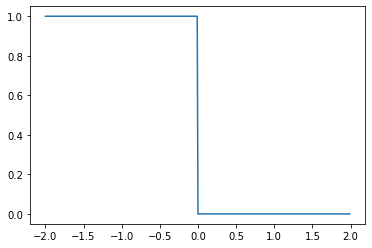

In [4]:
run_and_plot(zero_one)

In [5]:
# Hinge loss
def hinge(p,a):
    return max(0, 1 - p*a)

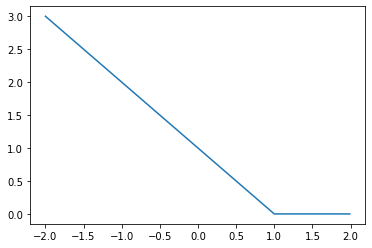

In [6]:
run_and_plot(hinge)

In [7]:
# Exponential, luckily numpy already has e defined for us
def exponential(p,a):
    return pow(np.e, -(p * a))

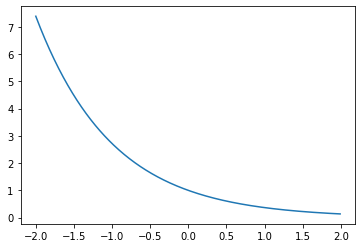

In [8]:
run_and_plot(exponential)

In [9]:
# Squared loss, very common!
def squared_loss(p,a):
    return pow(a - p, 2)

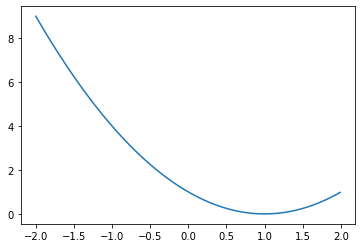

In [10]:
run_and_plot(squared_loss)

As you can see, squared loss is nice because at any point along the function you could figure out 'which way to go'!

However, squared loss isn't always used because it doesn't always make sense. What if the 'difference' between your prediction and the actual value is meaningless? Then squared-loss may not be appropriate. As always, you'll need to think about what your data means and what your model's prediction means.

# Gradient Descent

Now let's look at Gradient Descent, a versatile machine learning technique. Gradient Descent provides us a way of _iteratively_ minimizing (or maximizing) a function. Often these functions are some sort of statistical model (e.g. a linear regression). To make things really simple we're going to minimize the following function:

In [11]:
# We could use np.dot here, but let's be explicit for clarity
def sum_of_squares(v):
    return np.sum([i * i for i in v])

## The 'Gradient' in 'Gradient Descent'

As we discussed in class, the 'gradient' is a generalization of the derivative of a function, where the gradient represents a vector of partial derivatives. So if we had a way of calculating the gradient for any point in a function, it would tell us which 'way to go' in order to minimize that function (this should be rining all sorts of bells with what we wanted out of loss functions).

If there's a unique minimum (which isn't always the case), it may not even matter where we start, we can just pick a random point, calculate the gradient, and go in the appropriate direction.

What would be nice is if for any function we write in a programming language, we could _automatically_ get its gradient. In fact there's a who set of programming languages for this exact putpose (sometimes called 'differentiable programming languages' or 'probabilistic programming languages'). However, given an arbitrary function written in Python, we won't be able to automatically compute the gradient. As such, estimating the gradient is a big part of doing gradient descent.

We estimate the gradient in the same way we would estimate the derivative: calculate the difference between two _very close points_ (you may remember your secondary school definition of a derivative where you take the limit of a difference that approaches 0, it's very much like that). Just to remind you:

In [12]:
# for some function, and for some input to that function, compute the difference quotient for the given `h`
def estimate_derivative(f, x, h):
    return (f(x + h) - f(x)) / h

This is great for one dimension, but we'll be working in multiple dimensions, so  we have to estimate the vector of _partial derivatives_. It sounds scarier than it is:

In [13]:
# for some function, and for an input vector to that function, compute the difference quotient of the _ith_
# parameter given `h`.
# Main thing is that we only 'wiggle' the input vector at the given index.
def estimate_partial(f, v, i, h):
    new_v = [val + (h if d == i else 0) for d, val in enumerate(v)]
    
    return (f(new_v) - f(v)) / h

# Getting the vector of partial derivatives is now just doing that for every index
def estimate_gradient(f, v, h):
    return [estimate_partial(f,v,i,h) for i in range(len(v))]

Performing a single step of the algorith is easy when you have an input vector, a gradient, and a step-size:

In [14]:
# A single step of Gradient Descent
# We assume that the input vector and the length of the gradient match!!!
# We also parameterize the function with a step-size
def single_step(vec, grad, ss):
    # multiply our gradient by the scalar step-size
    step = np.multiply(grad, ss)
    # add the resulting step vector to our input vector
    return vec + step

Now that we have a way to estimate the gradient, we can start figuring out how we're going to navigate the search for the minimum. One way is to just pick a random starting point and go in the _opposite_ direction of the gradient (think about why it needs to be the opposite):

In [15]:
# random starting point
start = [np.random.uniform(-10,10) for i in range(3)]

# each 'epoch' is defined as the following:
#
# * estimate the gradient
# * take a step (opposite of the gradient)
v = start
for e in range(1000):
    g = estimate_gradient(sum_of_squares, v, 0.001)
    v = single_step(v, g, -0.01)
    
# We would hope that the resulting vector is close to 0 (because that's the minimum for our function)
print(v)

[-0.00049999 -0.0005     -0.00049999]


The more we run this, the close to 0 we should get (though it's possible we never reach zero!)

In [16]:
for e in range(1000):
    g = estimate_gradient(sum_of_squares, v, 0.001)
    v = single_step(v, g, -0.01)
    
print(v)

[-0.0005 -0.0005 -0.0005]


There are a few reasons we may never reach 0: numerical instability, floating point errors, etc. One such reason that is very much within our control is our step size. You could imagine a step size that's just too big, and we _would_ get to 0 but we 'over step' and end up on the other side. A very common approach to solving this issue is to gradually decrease the step size as you iterate.

## Using Gradient Descent to fit a Linear Model

Okay, let's try something a little more sophisticated: A linear model. The function we'll want to minimize is our _loss function_, which will represent the loss for a given prediction. For the linear model, our input vector represents the parameters to the model $\theta$. Our gradient is based on the loss function.

Our loss is known as a _residual_ here. The residual error is the difference between a prediction from a model and the value in the dataset. It's useful to have this term because we sometimes also want to talk about the _noise_ in the dataset, which is the difference between the observed value (in our dataset) and the 'real' value (that we can't know).

Let's write it out:

In [17]:
def estimate_linear_gradient(x, y, theta):
    m, b = theta        # slope and intercept
    y1 = m * x + b      # your high school math teacher would be proud
    
    residual = (y1 - y)        # the _residual error_ is the difference between
                               # our prediction and the value in the dataset
    #r_squared = residual ** 2  we don't actually need this, it's just here to show you
    
    # the above two lines are just an inlined version of the square loss function
    # we can cheat (by using calculus) and just use the actual derivative:
    return [2 * residual * x, 2 * residual]

The above code uses the gradient of the Squared Loss function, which determines the loss of our linear model at a single point. We'll also want to determine the loss for the entire dataset. For this _a very common_ approach is to use 'Mean Squared Error' (MSE). The gradient of MSE is the mean of the individual gradients computed above.

In this example, we'll use an actual linear function, and then a random starting point (remember a 'point' in this case is just a vector representing a slope and intercept).

Let's do it:

In [18]:
# Warning I used `np.mean` below and the algorith didn't work and it took me a _long_
# time to figure out that the bug was that I assumed it was a vector mean
# Also note that I would have found the bug way sooner had I actually asserted something
# I said above and made sure that the gradient and the input vector were the same shape!
# All that said, here's an actual vector mean
def v_sum(vs):
    return np.array([sum(v[i] for v in vs) for i in range(len(vs[0]))])

def v_mean(vs):
    return np.multiply(v_sum(vs), 1/len(vs))

# A linear relationship between `x` and `y`.
m = 42
b = 7
linear_rel = [(x, m * x + b) for x in range(-50, 50)]

# a random starting vector for the model we want to train
start_theta = [np.random.uniform(-1,1), np.random.uniform(-1,1)]

step_size = 0.001

theta = start_theta
for e in range(5000):
    predictions  = [estimate_linear_gradient(x, y, theta) for x, y in linear_rel]
    mse_gradient = v_mean(predictions)
    theta        = single_step(theta, mse_gradient, -step_size)
    
    
def is_close(a,b):
    return (a - 0.01) < b < (a + 0.01)

s, i = theta
if is_close(m,s) and is_close(b,i):
    print("we got close!")
else:
    print("we got so far!")

we got close!


## Downsides and alternatives

This is flexible, but _expensive_. We are calculating the residuals for the _entire dataset_ for _each epoch_. This is a cheap linear function and I still have to wait a few seconds on my machine. Imagine if this was an expensive model!

What we've implemented above is called 'Batch Gradient Descent'. Because it is expensive folks have come up with the following alternatives:

  * Minibatch: get a smaller batch by randomly sampling from the original dataset for each epoch
  * Stochastic: each gradient step is based on _one_ training example

A good exercise would be to modify the above code to work as minibatch or as stochastic gradient descent. Let me know if you do so!

As always, there's no 'right' answer here. All three come up in the real world. A big factor in your decision is going to be how expensive making a prediction is.

# Linear Regressions

The last thing we want to cover in this lecture is some information about Linear Regressions. We've already seen some aspects (what a residual is, how to fit a model to data, etc.) but we want to talk a little bit more about them.

While implementing our own gradient descent is fun, really you should use the Linear Model provided by some library. There are many to choose from:

* SciKit Learn
* Patsy (very cool!)
* Statsmodels

We'll be using SciKit Learn here, but you should definitely check out Patsy, it makes some things _way_ easier.

While Linear Regressions are great (they help us model all sorts of things, they scale well, they are easy to understand, etc.) you must be aware that whenver you use a Linear Regression you are _assuming_ the following 4 things:

1. That a linear relationship exists
2. Independence of residuals
3. Constant Variance of residuals (this is known as 'Homoscedasticity')
4. That the residuals are normally distributed (this is known as 'Normality')

The first seems obvious, but it bears keeping in mind: If there _isn't_ a linear relationship in your data, then your results are meaningless _even if they show that a linear model fits very well_ this is the classic 'correlation does not equal causation'. You have to have a plausible explanation for the linear relationship.

The second can be tricky. When using a linear model you are assuming that at each 'step' in one dimension, it does not have an effect on the _residuals_. In other words, if there is a correlation between one of the dimensions and the _residuals_ in the other dimension, this is bad and makes the model untrustworthy. This crops up a lot when dealing with time-series data.

The last two deal with the assumptions regarding how the residuals are distributed. If they are not normally distributed, and do not have a constant variance, there may be an issue with your model.

Sometimes the solutions is to add an _interaction_ term to your model.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [20]:
# A linear relationship between `x` and `y`. (same as before)
m = 5
b = 7
r = range(-50, 50)
ind = [ [i] for i in r] # notice this is a list of lists,
                        # the inner list length is the dimensionality
dep = [m * x + b + np.random.uniform(-10,10) for x in r]

Here we have some data, our independent variable `ind` and our dependent variable `dep` and we'd like to fit a linear model to it, sklearn has us covered (pretend we got the data from a dataset and now that we defined it ourselves):

In [21]:
lm = linear_model.LinearRegression()
lm.fit(ind,dep)

LinearRegression()

Now we can plot the regression compared to our dataset:

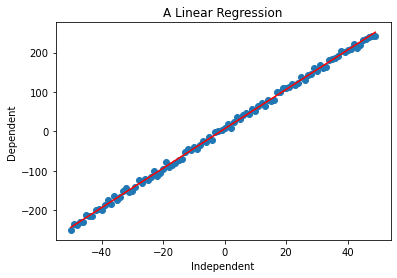

In [22]:
fig, ax = plt.subplots()
    
ax.scatter(ind, dep)
ax.set_xlabel("Independent")
ax.set_ylabel("Dependent")
ax.set_title("A Linear Regression")
    
ax.plot(ind, lm.predict(ind), color='red')

Now consider the following:

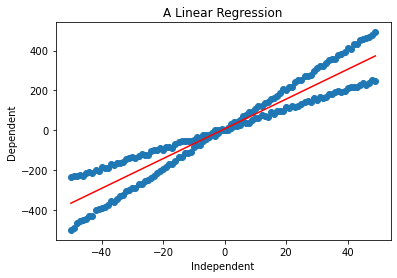

In [23]:
# A linear relationship between `x` and `y`. (same as before)
m = 5
m2 = 10
b = 7
r = range(-50, 50)

      # doesn't likes cats
ind = [ [i] for i in r] + [ [i] for i in r ]
                            # likes cats

dep = [m * x + b + np.random.uniform(-10,10) for x in r] + [m2 * x + b + np.random.uniform(-10,10) for x in r]

lm = linear_model.LinearRegression()
lm.fit(ind,dep)

fig, ax = plt.subplots()
    
ax.scatter(ind, dep)
ax.set_xlabel("Independent")
ax.set_ylabel("Dependent")
ax.set_title("A Linear Regression")
    
ax.plot(ind, lm.predict(ind), color='red')

This is a rather extreme example, meant to illustrate a point. This linear Regression is wrong, even though it has OK predictive power. The issue is that some other factor is _interacting_ with our model. What we need to do is teach the model about this interaction. This is known as an _interaction term_. In this case the interaction has to do with the _evenness_ of the value. While this is a numerical property, I want you to pretend it's a categorical property like, I don't know _country_ or _continent_ perhaps.

The idea is that we can convert any categorical property into a numerical one by creating a new dimension in our dataset that is 0 when the value is not in the category and 1 when it is. Let's look:

In [24]:
# This is the main change!!!
ind = [ [i,0] for i in r] + [ [i,1] for i in r] 

# notice our inner list is longer now!

So, now our independent variables have another dimension to them. Great!

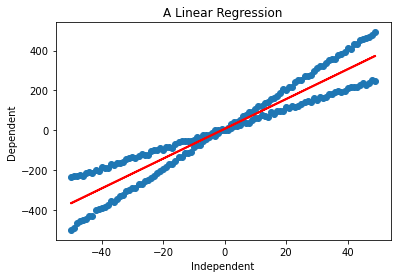

In [25]:

lm2 = linear_model.LinearRegression()
lm2.fit(ind,dep)

fig, ax = plt.subplots()

just_data = [i[0] for i in ind]
ax.scatter(just_data, dep)
ax.set_xlabel("Independent")
ax.set_ylabel("Dependent")
ax.set_title("A Linear Regression")
    
ax.plot(just_data, lm2.predict(ind), color='red')

It may not look very different in this form (though the red line is thicker), but we have reduced the residual error! Take a look!

In [26]:
print(f"Without interaction term at x = 1: {lm.predict([[1]])}\n")
print(f"With interaction term at x = 1: {lm2.predict([[1,0]])} (doesn't like cats), {lm2.predict([[1,1]])} (likes cats)\n")

Without interaction term at x = 1: [14.34814415]

With interaction term at x = 1: [16.05484008] (doesn't like cats), [12.64144823] (likes cats)



Before our linear model (`lm`) couldn't take 'liking cats' into account, so it had to give a prediction that was 'in the middle'. Now, like all good models, it (`lm2`) can give better predictions when it _does_ take it into account.

I didn't do this with Pandas, but a useful function when trying to add interaction terms with pands is `pd.get_dummies` (not a joke). This function will _automatically_ create the appropriate columns for you out of a categorical variable. However, beware of the dummy variable trap! I've fallen for it many times. You don't need a column for _every_ possible value of the categorical value, just enough to disambiguate. It's not just innefficient to have too many columns, it will result in a very innacurate model!

To relate it to what we did above, we didn't need a "likes cats" _and_ a "doesn't like cats" dimension, as just one dimension with 0 or 1 was enough. If it was "likes cats", "doesn't like cats", and "is neutral", you wouldn't need three  new columns, only two! One value can always be the 'default' so if you aren't  "is neutral" or "doesn't like cats" that _means_ you're "likes cats".